In [1]:
%load_ext autoreload
%autoreload 2

In [345]:
from L96 import *
from EnKF import *
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,7)
sns.set_style('dark')
sns.set_context('talk')
from IPython.display import clear_output

In [110]:
l96 = L96TwoLevel(noYhist=True)
l96.iterate(20)
init=l96.state
initX=l96.X
initY=l96.Y

In [145]:
l96_true = L96TwoLevel(dt=0.01, X_init=initX, Y_init=initY)

In [146]:
l96_true.iterate(1)

In [147]:
h = l96.history

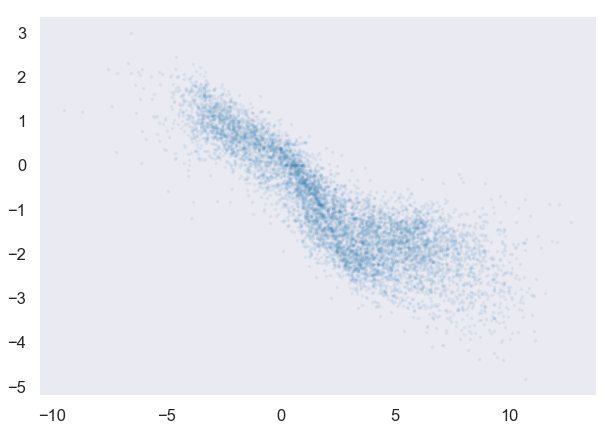

In [148]:
plt.scatter(np.ravel(h.X), np.ravel(h.B), s=5, alpha=0.05);

In [149]:
np.ravel(h.X).min(), np.ravel(h.X).max()

(-9.490528875206197, 12.710338342866804)

In [150]:
np.ravel(h.B).min(), np.ravel(h.B).max()

(-4.833095671303554, 2.9758038157175157)

In [250]:
X_quanta = np.arange(-4, 11)
X_quanta

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [298]:
B_quanta = np.arange(-4, 3)
B_quanta

array([-4, -3, -2, -1,  0,  1,  2])

In [299]:
nS = len(X_quanta)
nA = len(B_quanta)
nS, nA

(15, 7)

In [300]:
def quantize_X(X, X_quanta):
    idx = (np.abs(X_quanta[:, None] - X)).argmin(axis=0)
    return idx

In [301]:
def epsilon_greedy(state, Q, epsilon):
    rand_vec = np.random.uniform(size=len(state))
    rand_actions = np.random.randint(0, nA, size=len(state))
    actions = np.argmax(Q[state], axis=1)
    actions[rand_vec < epsilon] = rand_actions[rand_vec < epsilon]
    return actions        

In [302]:
def dequantize_B(B_idxs, B_quanta):
    return B_quanta[B_idxs]

In [303]:
class QParam():
    def __init__(self, Q, epsilon, X_quanta, B_quanta):
        self.Q = Q
        self.epsilon = epsilon
        self.X_quanta = X_quanta
        self.B_quanta = B_quanta
    def __call__(self, x):
        X_idxs = quantize_X(x, self.X_quanta)
        B_idxs = epsilon_greedy(X_idxs, self.Q, self.epsilon)
        self.actions = B_idxs
        B = dequantize_B(B_idxs, self.B_quanta)
        return B

In [304]:
qparam = QParam(Q, 0.1, X_quanta, B_quanta)

In [305]:
qparam(X_idxs)

IndexError: index 8 is out of bounds for axis 0 with size 7

In [306]:
l96Q = L96TwoLevel(noYhist=True, parameterization=qparam, X_init=initX, Y_init=initY)

In [307]:
l96Q.iterate(1)

IndexError: index 10 is out of bounds for axis 0 with size 7

(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([1.47339543, 1.57339543, 1.67339543, 1.77339543, 1.87339543,
        1.97339543, 2.07339543, 2.17339543, 2.27339543, 2.37339543,
        2.47339543]),
 <a list of 10 Patch objects>)

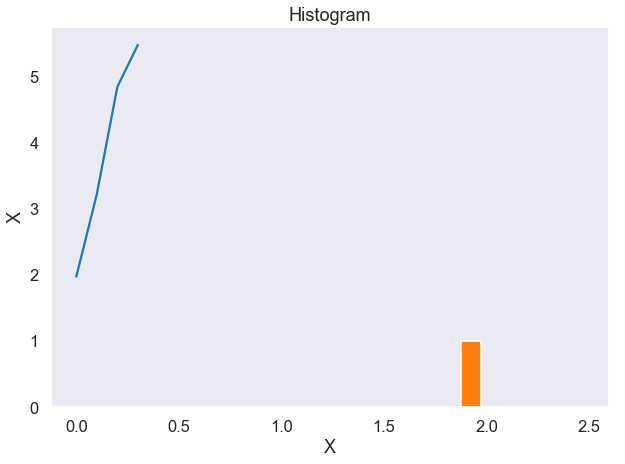

In [308]:
l96_true.history.X[:, 0].plot()
l96Q.history.X[:, 0].plot()

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-1.51526962, -1.41526962, -1.31526962, -1.21526962, -1.11526962,
        -1.01526962, -0.91526962, -0.81526962, -0.71526962, -0.61526962,
        -0.51526962]),
 <a list of 10 Patch objects>)

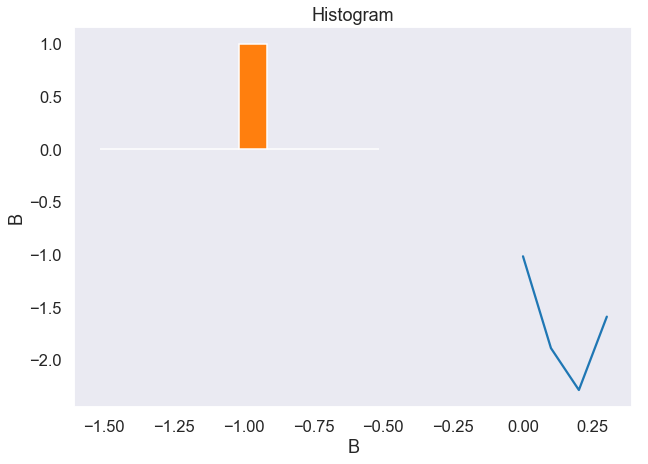

In [309]:
l96_true.history.B[:, 0].plot()
l96Q.history.B[:, 0].plot()

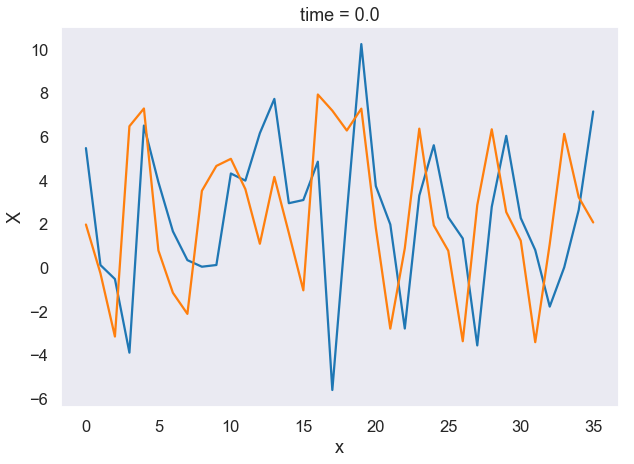

In [310]:
l96_true.history.X[-1].plot()
l96Q.history.X[-1].plot()

In [311]:
def reward(ltrue, lq):
    return -((ltrue.X - lq.X)**2).mean()

In [312]:
reward(l96_true, l96Q)

-18.926111332102128

## Q-Learning

In [313]:
class QParam():
    def __init__(self, Q, epsilon, X_quanta, B_quanta):
        self.Q = Q
        self.epsilon = epsilon
        self.X_quanta = X_quanta
        self.B_quanta = B_quanta
    def __call__(self, x):
        X_idxs = quantize_X(x, self.X_quanta)
        B_idxs = epsilon_greedy(X_idxs, self.Q, self.epsilon)
        self.actions = B_idxs
        B = dequantize_B(B_idxs, self.B_quanta)
        return B

In [314]:
qparam = QParam(Q, 0.1, X_quanta, B_quanta)

In [360]:
l96_true = L96TwoLevel(X_init=initX, Y_init=initY)

In [361]:
l96_true.iterate(1)

In [362]:
Q = np.zeros((nS, nA))
gamma = 0.99
alpha = 0.1
nsteps = 1000
history = []
epsilon = 1
Qhist = [Q.copy()]
qparam = QParam(Q, epsilon, X_quanta, B_quanta)
for episode in tqdm(range(1000)):
    l96Q = L96TwoLevel(noYhist=True, parameterization=qparam, 
                       X_init=initX, Y_init=initY)
    states = quantize_X(l96Q.X, X_quanta)
    for step in range(nsteps):
        l96Q.step()
        actions = qparam.actions
        next_states = quantize_X(l96Q.X, X_quanta)
        next_actions = epsilon_greedy(next_states, Q, 0)
        r = reward(l96_true, l96Q) if step == nsteps-1 else 0
        for s in range(len(states)):
            td_target = r + gamma * Q[next_states[s], next_actions[s]]
            td_error = td_target - Q[states[s], actions[s]]
            qparam.Q[states[s], actions[s]] += alpha * td_error
        states = next_states
        epsilon = epsilon / 1.003
        qparam.epsilon = epsilon
    history.append(r)
    Qhist.append(qparam.Q.copy())

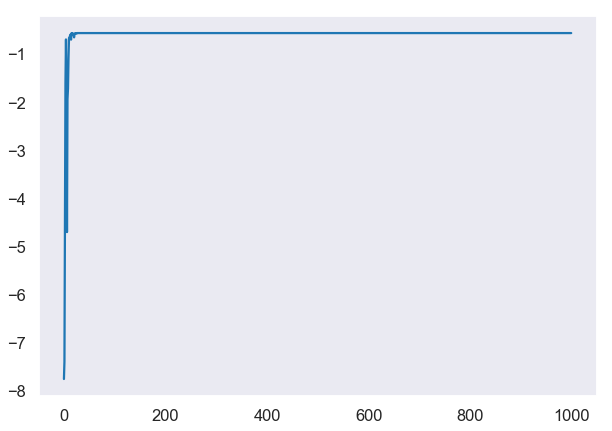

In [363]:
plt.plot(history)

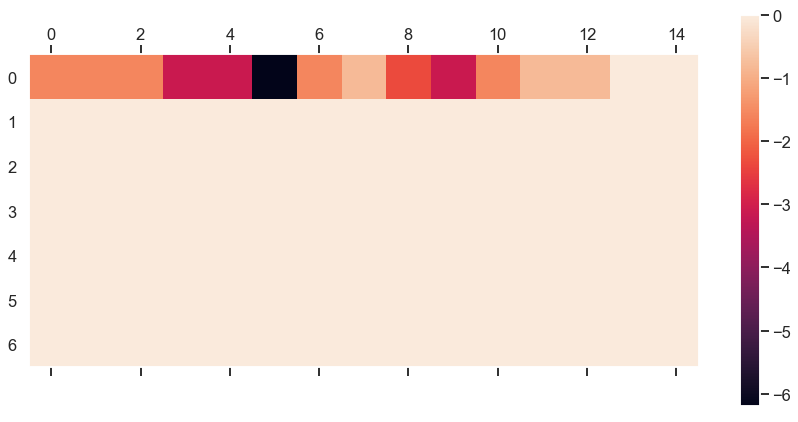

In [364]:
plt.matshow(Qhist[1].T)
plt.colorbar()

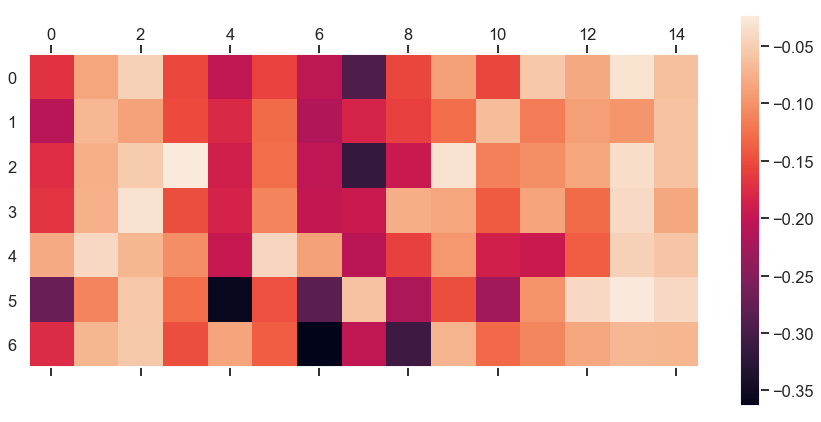

In [350]:
plt.matshow(Qhist[-1].T)
plt.colorbar()

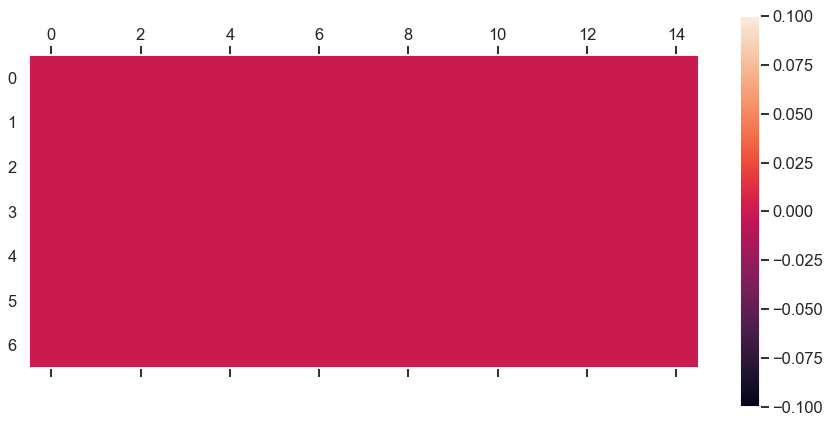

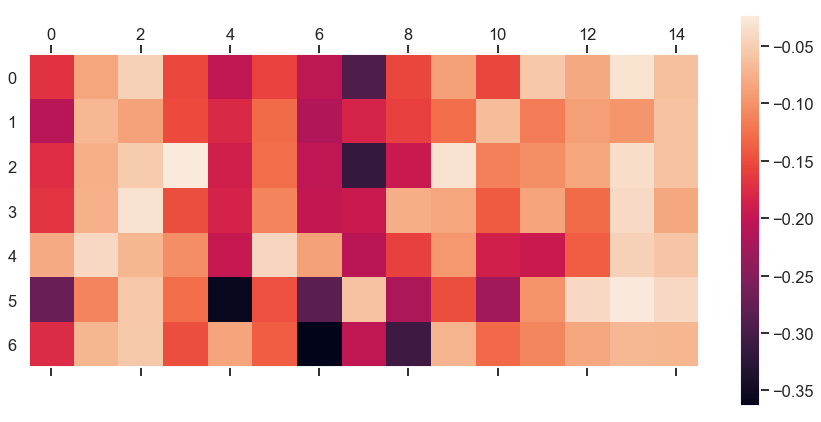

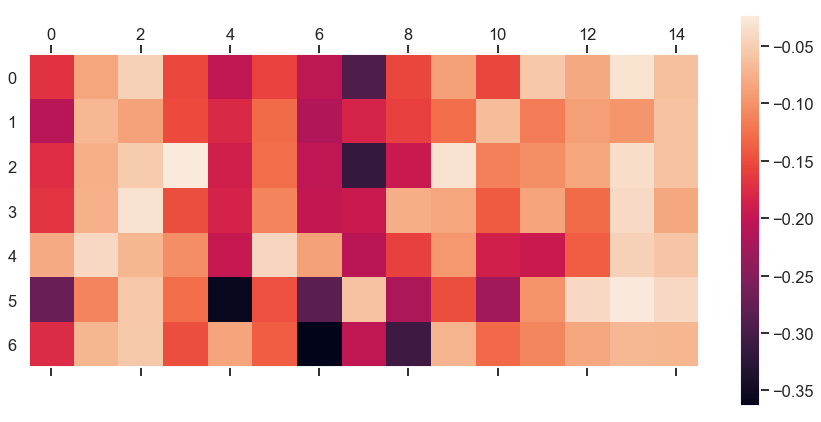

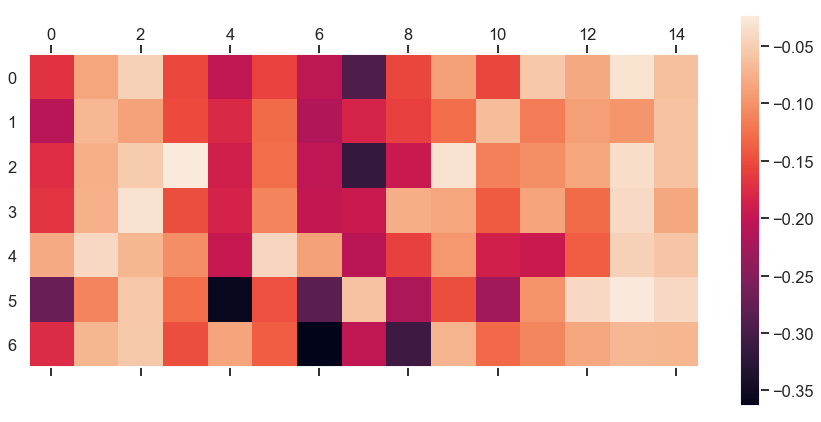

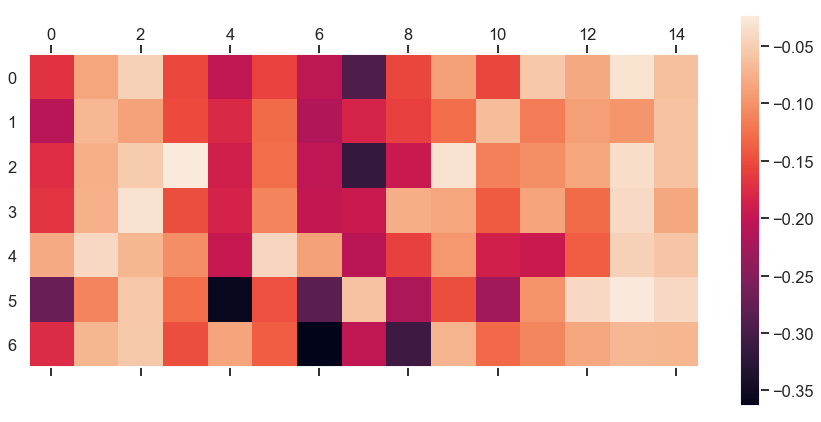

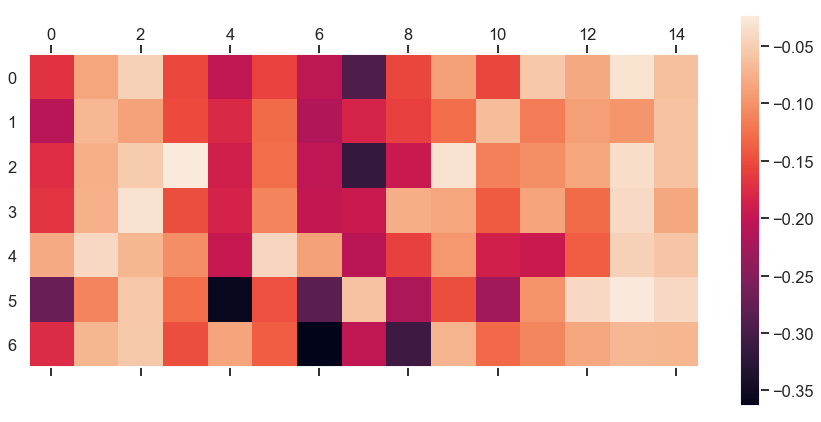

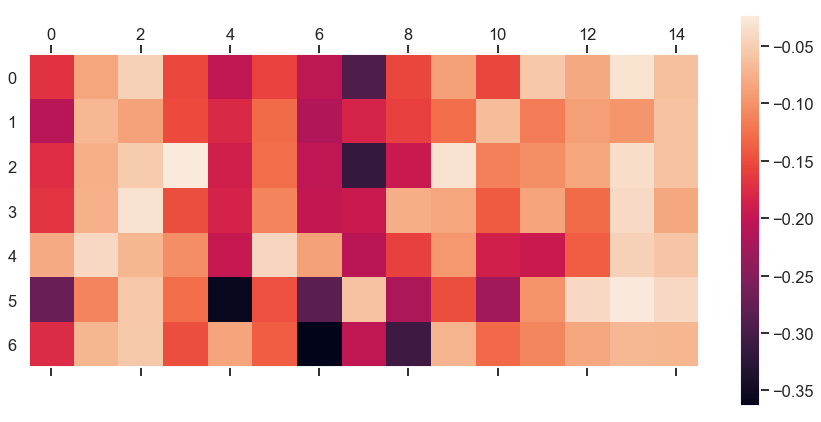

In [351]:
for i in range(0, 301, 50):
    plt.matshow(Qhist[i].T)
    plt.colorbar()

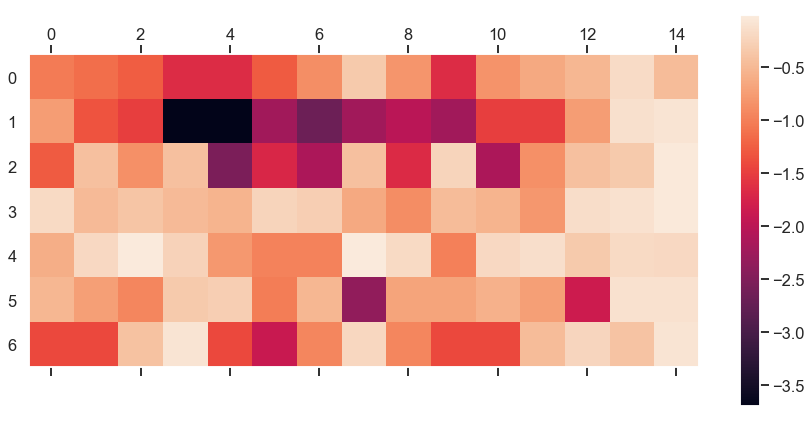

In [366]:
plt.matshow(Qhist[-1].T)
plt.colorbar()

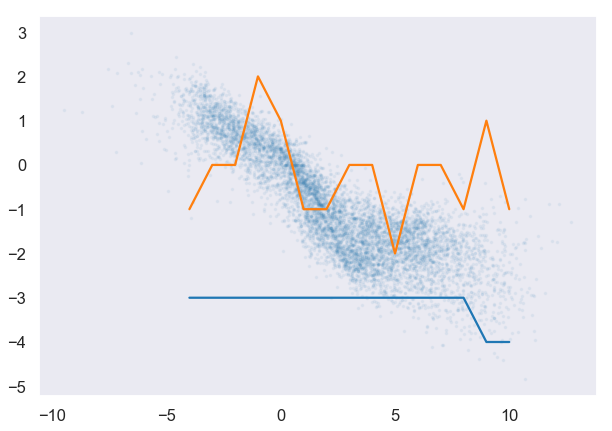

In [368]:
plt.scatter(np.ravel(h.X), np.ravel(h.B), s=5, alpha=0.05)
plt.plot(X_quanta, dequantize_B(np.argmax(Qhist[1], 1), B_quanta))
plt.plot(X_quanta, dequantize_B(np.argmax(Qhist[-1], 1), B_quanta))

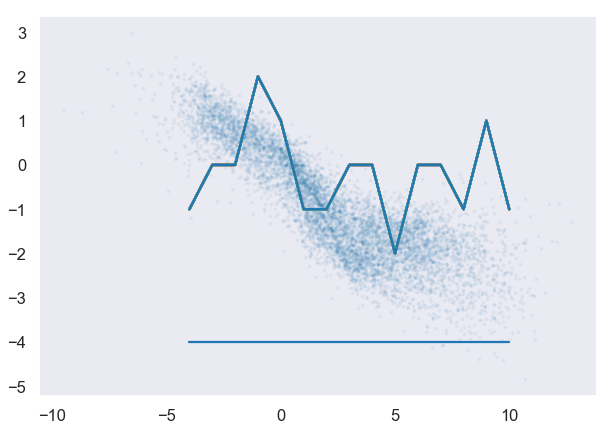

In [367]:
plt.scatter(np.ravel(h.X), np.ravel(h.B), s=5, alpha=0.05)
for i in range(0, 1001, 50):
    plt.plot(X_quanta, dequantize_B(np.argmax(Qhist[i], 1), B_quanta))

In [334]:
r

-0.03896345861158173

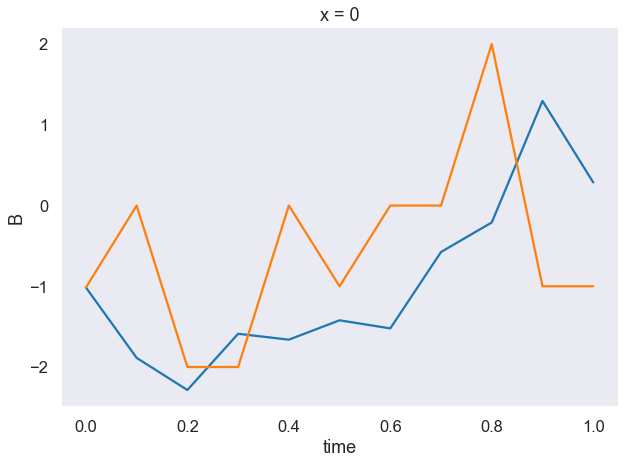

In [369]:
l96_true.history.B[:, 0].plot()
l96Q.history.B[:, 0].plot()

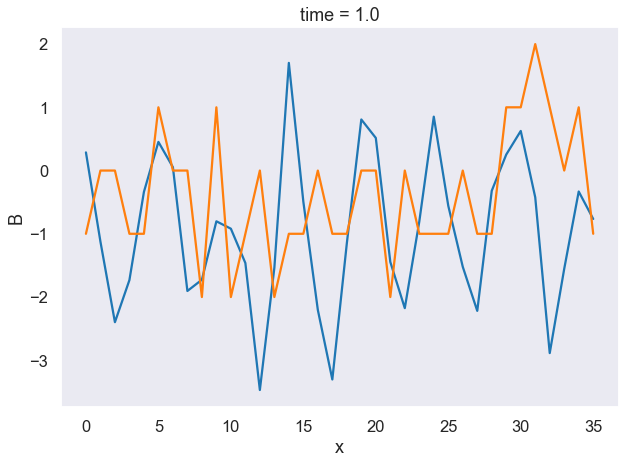

In [370]:
l96_true.history.B[-1].plot()
l96Q.history.B[-1].plot()

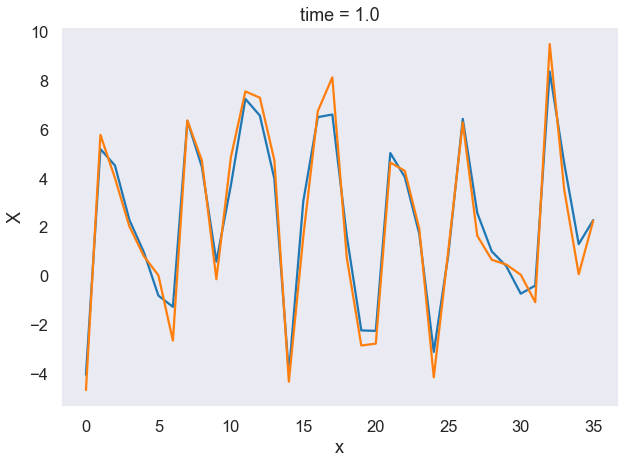

In [371]:
l96_true.history.X[-1].plot()
l96Q.history.X[-1].plot()